# NYC Taxi Fare Prediction

In this project, the goal is to build a model and predict the taxi fare in NYC, given time, geographic coordinates of pickup and dropoff location and number of passengers. In original dataset, we have around 55 million rows.

## Loading Original Data

First we set pandas `display.float_format` option to only display 3 digits for better formatting. 

In original dataset, the `key` column contains duplicate information as `pickup_datetime` column. We will not make use of that column, so drop it here. Also drop any null rows.

In [38]:
import math
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt
from geopy.distance import geodesic

pandas.set_option('display.float_format', lambda x: '%.3f' % x)

df = pandas.read_csv('sample.csv', parse_dates = ['pickup_datetime'])
df = df.drop(columns = 'key').dropna()

Now take a look at the loaded data:

In [39]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500,2009-06-15 17:26:21,-73.844,40.721,-73.842,40.712,1
1,16.900,2010-01-05 16:52:16,-74.016,40.711,-73.979,40.782,1
2,5.700,2011-08-18 00:35:00,-73.983,40.761,-73.991,40.751,2
3,7.700,2012-04-21 04:30:42,-73.987,40.733,-73.992,40.758,1
4,5.300,2010-03-09 07:51:00,-73.968,40.768,-73.957,40.784,1


We can preview the data by showing its descriptive statistics. The statistics will also help us cleaning the data.

In [40]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,99999.000,99999.000,99999.000,99999.000,99999.000,99999.000
mean,11.355,-72.495,39.914,-72.491,39.919,1.674
std,9.717,10.694,6.226,10.471,6.213,1.300
min,-44.900,-736.550,-74.008,-84.654,-74.006,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.963,40.768,2.000
max,200.000,40.788,401.083,40.851,404.617,6.000


We can see that there are several suspicious outliers. The minimum value of `pickup_longitude` and maximum value of `pickup_latitude` are impossible. Some other values like 0 and 208 in `passenger_count` should also be considered as fault rows.


## Task 1: Cleaning the Data

##### Taxi fare
The base taxi fare of NYC yellow cab is $2.50. For the upper bound, by intuition, the taxi fare within NYC does not exceed $100 in general cases. 

##### Pickup & Dropoff Locations
By investigating geographic coordinates on Google Map, I found that the difference of latitude and longitude value of 2 extremal points in NYC is less than 2%. Therefore, we will take 2% and 98% percentile of pickup and dropoff location and exclude those does not lie in that range.

##### Passenger Count
In NYC the maximum amount of passengers allowed in a yellow taxicab by law is 4, except that a child under age of 7 is allowed as an extra passenger. A mini van may take up to 7 passengers. We will drop all rows with `passenger_count` is less than 1 or larger than 7.

In [41]:
df = df.drop(df[(df.fare_amount < 2.5) | (df.fare_amount > 100)].index)

df = df.drop(df[(df.pickup_longitude < -75.462) | (df.pickup_longitude > -72.502)].index)
df = df.drop(df[(df.pickup_latitude < 39.937) | (df.pickup_latitude > 41.568)].index)
df = df.drop(df[(df.dropoff_longitude < -75.460) | (df.dropoff_longitude > -72.500)].index)
df = df.drop(df[(df.dropoff_latitude > 41.568) | (df.dropoff_latitude < 39.937)].index)

df = df.drop(df[(df.passenger_count < 1) | (df.passenger_count > 7)].index)

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97484.000,97484.000,97484.000,97484.000,97484.000,97484.000
mean,11.305,-73.975,40.751,-73.974,40.752,1.681
std,9.371,0.041,0.031,0.039,0.034,1.299
min,2.500,-75.425,39.993,-75.355,39.993,1.000
25%,6.000,-73.992,40.737,-73.991,40.736,1.000
50%,8.500,-73.982,40.754,-73.980,40.754,1.000
75%,12.500,-73.968,40.768,-73.965,40.768,2.000
max,100.000,-72.857,41.523,-72.855,41.543,6.000


### Calculating Euclidean and Geographic Distance

We will calculate euclidean and geographic distance between pickup and dropoff location in the dataset. Since we have already dropped invalid ones of latitude and longitude values, we can simply apply both distance function to all rows and generate 2 new columns: `eu_distance` as Euclidean distance and `geo_distance` as geographic distance. The grographic distance is in kilometers(km).

In [52]:
def eu_distance(row):
    return (((row['pickup_latitude'] - row['dropoff_latitude']) ** 2) + 
            (row['pickup_longitude'] - row['dropoff_longitude']) ** 2) ** (1/2)

def geo_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return geodesic(pickup, dropoff).km

df['eu_distance'] = df.apply(eu_distance, axis=1)
df['geo_distance'] = df.apply(geo_distance, axis=1)

df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day
count,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000
mean,49977.889,11.286,-73.976,40.751,-73.974,40.751,1.682,0.035,3.367,50377.704
std,28862.706,9.251,0.035,0.027,0.035,0.031,1.300,0.039,3.587,23439.116
min,0.000,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010,0.000
25%,24984.500,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287,33878.500
50%,49972.000,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.188,52669.000
75%,74973.500,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.967,70234.000
max,99998.000,100.000,-72.857,41.523,-72.855,41.543,6.000,0.686,57.935,86397.000


We will drop rows which pickup and dropoff locations being too close (less than 0.01km) or too far (more than 60km).

In [53]:
df = df.drop(df[(df.geo_distance > 60) | (df.geo_distance < 0.01)].index)

df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day
count,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000
mean,49977.889,11.286,-73.976,40.751,-73.974,40.751,1.682,0.035,3.367,50377.704
std,28862.706,9.251,0.035,0.027,0.035,0.031,1.300,0.039,3.587,23439.116
min,0.000,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010,0.000
25%,24984.500,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287,33878.500
50%,49972.000,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.188,52669.000
75%,74973.500,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.967,70234.000
max,99998.000,100.000,-72.857,41.523,-72.855,41.543,6.000,0.686,57.935,86397.000


Save cleaned data to csv file to prevent repeated works.

In [54]:
df.to_csv('cleaned.csv')

From now we can directly read from cleaned dataset.

In [55]:
df = pandas.read_csv('cleaned.csv')
df.describe()

,Unnamed: 0,Unnamed: 0.1,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day
count,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000
mean,48077.000,49977.889,11.286,-73.976,40.751,-73.974,40.751,1.682,0.035,3.367,50377.704
std,27757.702,28862.706,9.251,0.035,0.027,0.035,0.031,1.300,0.039,3.587,23439.116
min,0.000,0.000,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010,0.000
25%,24038.500,24984.500,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287,33878.500
50%,48077.000,49972.000,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.188,52669.000
75%,72115.500,74973.500,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.967,70234.000
max,96154.000,99998.000,100.000,-72.857,41.523,-72.855,41.543,6.000,0.686,57.935,86397.000


## Task 2: Computing Pearson correlation

We will compute pearson correlation between:
 - Euclidean distance of the ride and the taxi fare
 - time of day and distance traveled
 - time of day and the taxi fare
 
First, parse `pickup_datetime` to time of days into a new column. The time of the day is represented as integer timestamp in seconds, for instance, 00:00:01 is 1 and 01:00:00 is 3600.

In [56]:
def parse_time_of_day(time):
    time = time.str.extract('(\d\d:\d\d:\d\d)', expand=False)
    hour = time.str.slice(0, 2).astype(int)
    minute = time.str.slice(3, 5).astype(int)
    second = time.str.slice(6).astype(int)
    return hour * 3600 + minute * 60 + second

df['time_of_day'] = parse_time_of_day(df['pickup_datetime'])

df.describe()

,Unnamed: 0,Unnamed: 0.1,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,eu_distance,geo_distance,time_of_day
count,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000,96155.000
mean,48077.000,49977.889,11.286,-73.976,40.751,-73.974,40.751,1.682,0.035,3.367,50377.704
std,27757.702,28862.706,9.251,0.035,0.027,0.035,0.031,1.300,0.039,3.587,23439.116
min,0.000,0.000,2.500,-75.415,40.122,-75.355,40.165,1.000,0.000,0.010,0.000
25%,24038.500,24984.500,6.000,-73.992,40.737,-73.991,40.736,1.000,0.013,1.287,33878.500
50%,48077.000,49972.000,8.500,-73.982,40.754,-73.980,40.754,1.000,0.022,2.188,52669.000
75%,72115.500,74973.500,12.500,-73.968,40.768,-73.965,40.768,2.000,0.039,3.967,70234.000
max,96154.000,99998.000,100.000,-72.857,41.523,-72.855,41.543,6.000,0.686,57.935,86397.000


In [57]:
corr1 = df['fare_amount'].corr(df['eu_distance'])
corr2 = df['time_of_day'].corr(df['eu_distance'])
corr3 = df['time_of_day'].corr(df['fare_amount'])

print("Pearson correlation between Euclidesn distance and taxi fare: %.3f" % corr1)
print("Pearson correlation between time of the day and Euclidean distance: %.3f" % corr2)
print("Pearson correlation between time of the day and taxi fare: %.3f" % corr3)

Pearson correlation between Euclidesn distance and taxi fare: 0.901
Pearson correlation between time of the day and Euclidean distance: -0.033
Pearson correlation between time of the day and taxi fare: -0.020


## Task 3: Visualizing the Relation

The figures in the first row are relations using Euclidean distance whereas the second row is using geographic distance.

/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'parsed_time to fare_amount')

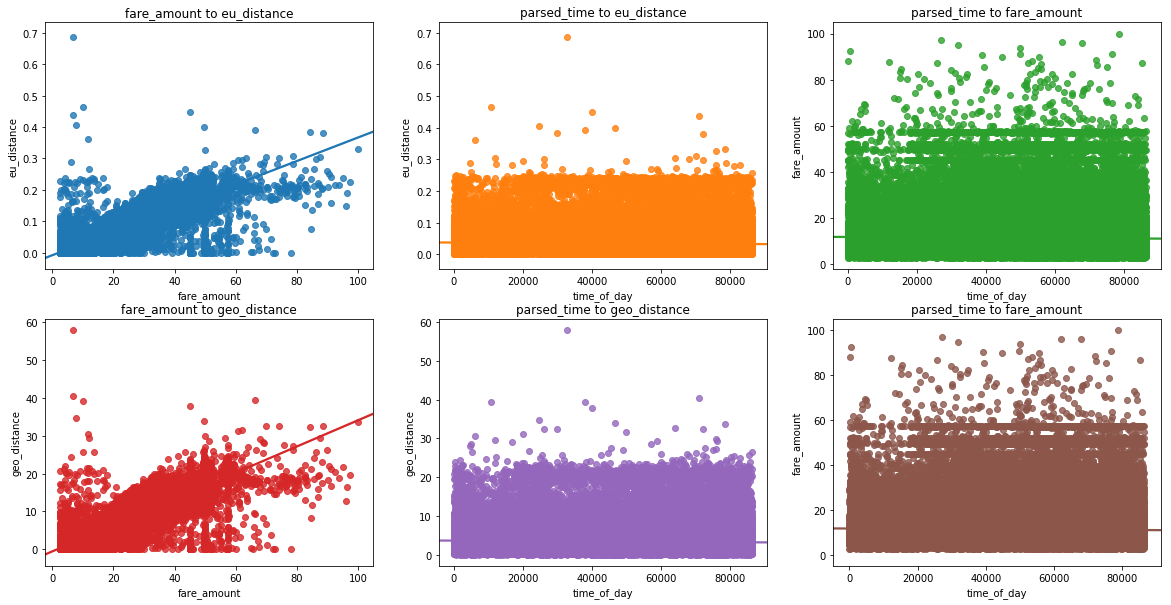

In [58]:
figure, axes = plt.subplots(2, 3, figsize = (20, 10), sharex=False, sharey=False)

seaborn.regplot(x="fare_amount", y="eu_distance", data=df, ax = axes[0][0])
axes[0][0].set_title('fare_amount to eu_distance')

seaborn.regplot(x="time_of_day", y="eu_distance", data=df, ax = axes[0][1])
axes[0][1].set_title('parsed_time to eu_distance')

seaborn.regplot(x="time_of_day", y="fare_amount", data=df, ax = axes[0][2])
axes[0][2].set_title('parsed_time to fare_amount')

seaborn.regplot(x="fare_amount", y="geo_distance", data=df, ax = axes[1][0])
axes[1][0].set_title('fare_amount to geo_distance')

seaborn.regplot(x="time_of_day", y="geo_distance", data=df, ax = axes[1][1])
axes[1][1].set_title('parsed_time to geo_distance')

seaborn.regplot(x="time_of_day", y="fare_amount", data=df, ax = axes[1][2])
axes[1][2].set_title('parsed_time to fare_amount')

## Task 4: Create Plots

/Users/sshao/workspace/nyc-taxi-fare-prediction/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'passenger_count to eu_distance')

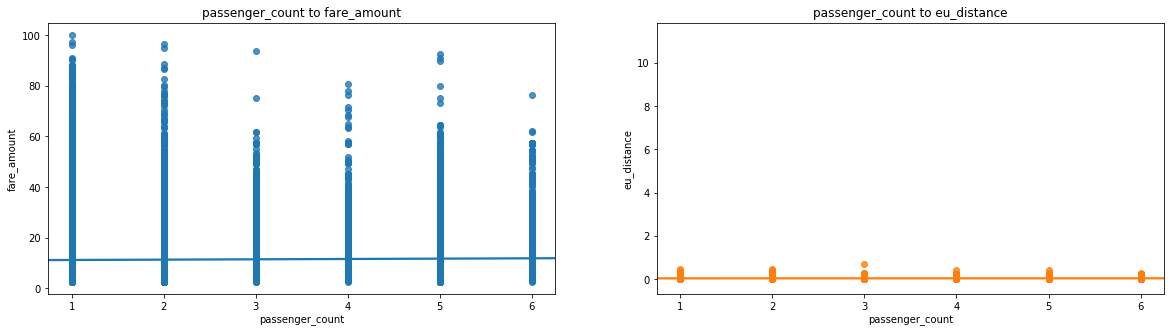

In [59]:
figure, axes = plt.subplots(1, 2, figsize = (20, 5), sharex=False, sharey=False)

seaborn.regplot(x="passenger_count", y="fare_amount", data=df, ax = axes[0])
axes[0].set_title('passenger_count to fare_amount')

seaborn.regplot(x="passenger_count", y="eu_distance", data=df, ax = axes[1])
axes[1].set_title('passenger_count to eu_distance')


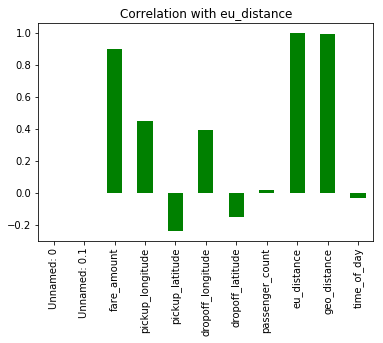

In [60]:
corrs = df.corr(method='pearson')

corrs['eu_distance'].plot.bar(color = 'g');
plt.title('Correlation with eu_distance');

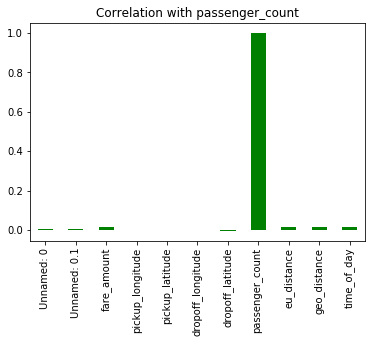

In [61]:
corrs['passenger_count'].plot.bar(color = 'g');
plt.title('Correlation with passenger_count');

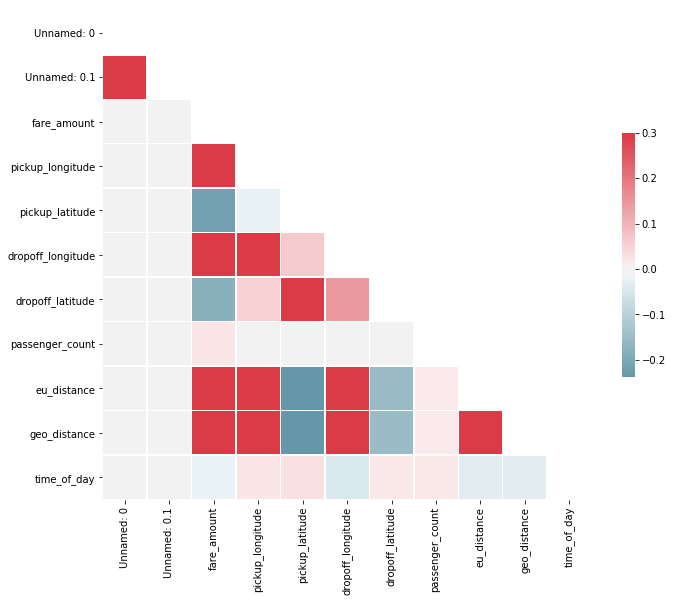

In [62]:
# Generate a mask for the upper triangle
mask = numpy.zeros_like(corrs, dtype=numpy.bool)
mask[numpy.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corrs, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})